In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as Trans
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch
import torch.nn as nn

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# Define image size for preprocessing; and batch size
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
dataroot = "/content/drive/MyDrive/disney-dataset/train"

# Creating a DataLoader for the train dataset with specified transformations
trainloader = datasets.ImageFolder(dataroot, transform = Trans.Compose([
            Trans.Resize(image_size),
            Trans.CenterCrop(image_size),
            Trans.ToTensor(),
            Trans.Normalize(*stats)]))

# Creating batches of train data with DataLoader
trainloader = DataLoader(trainloader, batch_size, shuffle = True, num_workers = 3, pin_memory = True)

total_train_images = len(trainloader.dataset)
print("Total number of images in the train dataset:", total_train_images)

Total number of images in the train dataset: 2674


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
dataroot = "/content/drive/MyDrive/disney-dataset/test"

# Creating a DataLoader for the test dataset with specified transformations
testloader = datasets.ImageFolder(dataroot, transform = Trans.Compose([
           Trans.Resize(image_size),
           Trans.CenterCrop(image_size),
           Trans.ToTensor(),
           Trans.Normalize(*stats)]))

# Creating batches of test data with DataLoader
testloader = DataLoader(testloader, batch_size, shuffle = True, num_workers = 3, pin_memory = True)

total_test_images = len(testloader.dataset)
print("Total number of images in the test dataset:", total_test_images)

Total number of images in the test dataset: 376


In [6]:
# Categories for the Disney characters
classes = ("donald", "mickey", "minion", "olaf", "pooh")

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


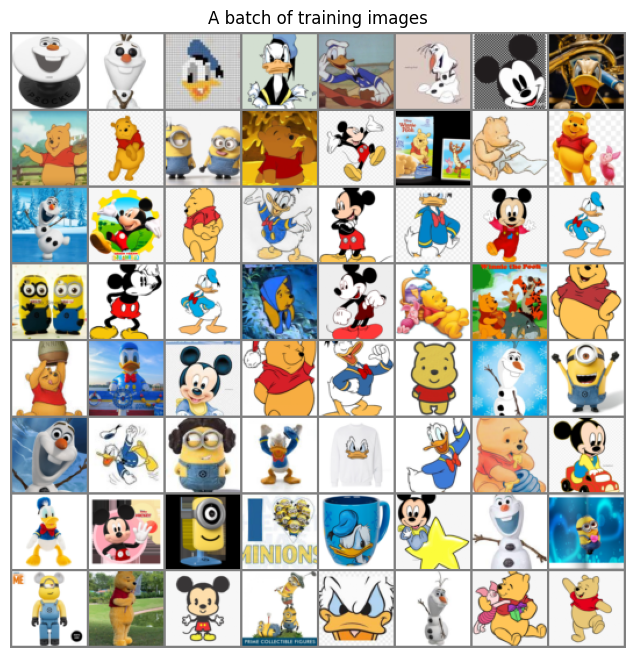

In [7]:
def imshow(img, title):
    img = img / 2 + 0.5  # Denormalize the image tensor
    imgnp = img.numpy()

    plt.figure(figsize = (8, 8))
    plt.title(title)
    plt.imshow(np.transpose(imgnp, (1, 2, 0)))  # Display the image, transposing channels to (H, W, C) format
    plt.axis("off")
    plt.show()

# Get a batch of training images and labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Display a batch (64) of images
imshow(torchvision.utils.make_grid(images), "A batch of training images")

In [8]:
# Shape of the 'images' and 'labels' tensor
print("images:", images.shape)
print("labels:", labels.shape)

images: torch.Size([64, 3, 64, 64])
labels: torch.Size([64])


In [9]:
# Define a neural network for image classification
class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()

      # Convolutional layers for feature extraction
      self.cnn_layers = nn.Sequential(
          nn.Conv2d(3, 4, kernel_size = 3, stride = 1, padding = 1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace = True),
          nn.MaxPool2d(kernel_size = 2, stride = 2),
          nn.Conv2d(4, 4, kernel_size = 3, stride = 1, padding = 1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace = True),
          nn.MaxPool2d(kernel_size = 2, stride = 2))

      # Fully connected layers for classification
      self.linear_layers = nn.Sequential(
          nn.Linear(4 * 16 * 16, 5))

  def forward(self, x):
      # Forward pass through the network
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x

In [10]:
# Define a neural network model for image classification
model = Net()

# Define the optimization algorithm (Adam) with a learning rate of 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

# Define the loss function for classification problems (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# Move the model and loss function to the GPU if available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

# Print the architecture of the neural network
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1024, out_features=5, bias=True)
  )
)


In [11]:
# Check if CUDA (GPU support) is available, and set the device accordingly, else use the CPU
if torch.cuda.is_available():
  torch.device("cuda")
else:
  torch.device("cpu")

In [12]:
# Training the model for 11 epochs
for epoch in range(11):
    running_loss = 0

    # Iterating through the training dataset in batches
    for images, labels in trainloader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        # Zeroing the gradients, as PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # Forward pass: computing model predictions
        output = model(images)

        # Computing the loss between the predictions and ground truth labels
        loss = criterion(output, labels)

        # Backward pass: computing gradients and updating model parameters
        loss.backward()
        optimizer.step()

        # Accumulating the running loss for the current epoch
        running_loss += loss.item()

    # Printing the average training loss for the current epoch
    print("Epoch {} - Training loss: {}".format(epoch + 1, running_loss / len(trainloader)))

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 1 - Training loss: 1.2822596331437428


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2 - Training loss: 0.7724685037419909


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 3 - Training loss: 0.6854201746838433


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 4 - Training loss: 0.5819934535594213


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 5 - Training loss: 0.47652578070050194


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 6 - Training loss: 0.4055323430470058


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7 - Training loss: 0.37838165426538106


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 8 - Training loss: 0.2753074484921637


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 9 - Training loss: 0.256634353527001


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 10 - Training loss: 0.22131309729246867


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 11 - Training loss: 0.17916280882699148


In [13]:
# Save the model after training
torch.save(model.state_dict(), 'pretrained_model.pth')

In [14]:
tot_images = 0
corr_images = 0

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for images, labels in testloader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        # Forward pass
        output = model(images)

        # Calculate probabilities and predictions
        ps = torch.exp(output)
        pred_labels = torch.argmax(ps, dim = 1)

        # Update counters
        corr_images += torch.sum(pred_labels == labels).item()
        tot_images += labels.size(0)

model.train()  # Set the model back to training mode

print("\nNumber of tested images:", tot_images)
print("Number of correctly classified images:", corr_images)
print("Model accuracy: {:.3f}%".format(corr_images / tot_images * 100))


Number of tested images: 376
Number of correctly classified images: 331
Model accuracy: 88.032%


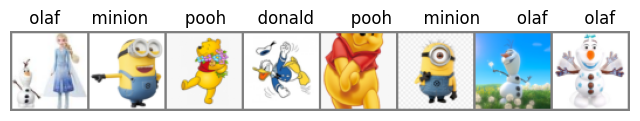

In [15]:
# Extract the predicted labels using argmax along dimension 1 (columns)
_, predicted = torch.max(output, 1)

# Select the first 8 images from the batch and clone them to CPU
images_to_show = images[:8].cpu().clone()

# Display the images in a grid with corresponding predicted labels
imshow(torchvision.utils.make_grid(images_to_show), "      ".join("%5s" % classes[predicted[j]] for j in range(8)))